# Geodesic Example

First, we import the necessary modules.

In [7]:
%load_ext autoreload
%autoreload 2

from fadge.metric import KerrSchild
from fadge.geode  import Geode
from fadge.utils  import Nullify

from jax          import numpy as np
from matplotlib   import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Select spin and find the outer horizon

In [8]:
aspin = 0.9
rp = 1.0 + np.sqrt(1 - aspin * aspin)

print('Outer horizon:', rp)

Outer horizon: 1.43589


We then create the `metric`, `nullify`, and `run` functions

In [9]:
metric  = KerrSchild(rp)
nullify = Nullify(metric)

def run(l, x):
    aa = aspin * aspin
    zz = x[3] * x[3]
    kk = 0.5 * (x[1] * x[1] + x[2] * x[2] + zz - aa)
    rr = np.sqrt(kk * kk + aa * zz) + kk
    r  = np.sqrt(rr)
    return r >= rp + 1e-2

And the initial condition of a null geodesic.

In [10]:
s = []
for i in range(-4,4):
    x =            np.array([0,1000,-i,4.9])
    v = nullify(x, np.array([1,   1, 0,0  ]))
    s.append(np.concatenate([x, v]))
s = np.array(s).T

print(s.shape)

(8, 8)


Using these, we can create a geodesic precomputed from $\lambda = 0$ to $-2000$.

In [11]:
geode = Geode(metric, np.array(0.0), s, L=-2000, eqax=[0], filter=run)

/Users/ckc/Library/Python/3.9/lib/python/site-packages/jax/experimental/maps.py:517: UserWarning: xmap is an experimental feature and probably has bugs!
  warn("xmap is an experimental feature and probably has bugs!")


In [12]:
f = geode.states
print(f.shape)

l = np.linspace(-900,-1100,2001)
i = geode(l)

(75, 8, 8)


Here's the result from the full domain.  Note that, thanks to adaptive time stepping, the step size far away from the black hole is large.

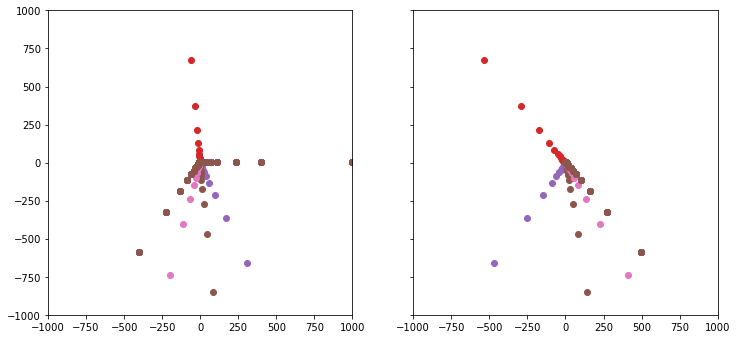

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12), sharey=True)

for j in range(16):
    ax1.scatter(f[:,1,j], f[:,3,j],      color=f'C{j}')
    ax1.scatter(i[:,1,j], i[:,3,j], s=1, color=f'C{j}')
    ax2.scatter(f[:,2,j], f[:,3,j],      color=f'C{j}')
    ax2.scatter(i[:,2,j], i[:,3,j], s=1, color=f'C{j}')
    
ax1.set_xlim(-1000,1000)
ax1.set_ylim(-1000,1000)
ax1.set_aspect('equal')

ax2.set_xlim(-1000,1000)
ax2.set_ylim(-1000,1000)
ax2.set_aspect('equal')

Zoomed-in

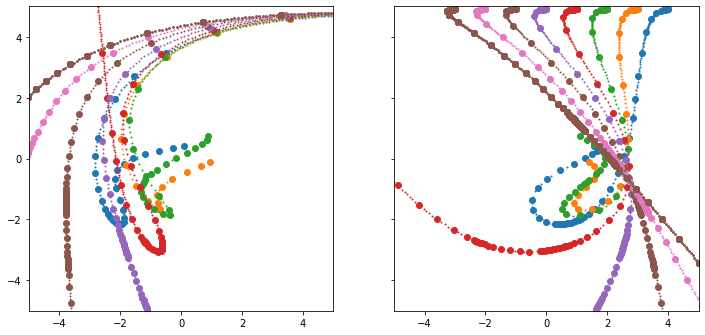

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12), sharey=True)

for j in range(16):
    ax1.scatter(f[:,1,j], f[:,3,j],      color=f'C{j}')
    ax1.scatter(i[:,1,j], i[:,3,j], s=1, color=f'C{j}')
    ax2.scatter(f[:,2,j], f[:,3,j],      color=f'C{j}')
    ax2.scatter(i[:,2,j], i[:,3,j], s=1, color=f'C{j}')
    
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_aspect('equal')

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)
ax2.set_aspect('equal')